In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import shap
from feature_engine.selection import DropCorrelatedFeatures

In [2]:
# 타이타닉데이터로 보루타 알고리즘으로 피처를 선정하자!
df = sns.load_dataset('titanic')

#데이터 전처리 
df = df.dropna(subset=['age','embarked','deck'])
df['sex'] =df['sex'].map({'male':0,'female':1})
df['embarked'] =df['embarked'].astype('category').cat.codes
df['deck'] = df['deck'].astype('category').cat.codes

#필요한 피처만 추출
X = df[['pclass','sex','age','sibsp','parch','fare','embarked','deck']]
y = df['survived']

In [3]:
## 보루타를 통한 피처셀렉션을 위해 RandomForestClassifier
rf= RandomForestClassifier(class_weight = 'balanced', max_depth=5)

# BorutaPy 불러오기
boruta_selector = BorutaPy(rf, n_estimators = 'auto', random_state=111)
boruta_selector.fit(X.values, y.values) #행렬로 대입해서

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=80,
                                          random_state=RandomState(MT19937) at 0x315657540),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x315657540)

In [4]:
print('선택된 특성',X.columns[boruta_selector.support_].tolist())

선택된 특성 ['sex', 'age', 'fare']


* 쉐도우 변수: 무작위로 섞은 특성을 만들어 중요도의 기준점으로 사용.
* 특성 선택 기준: 특성의 중요도가 쉐도우 변수보다 높아야 함.
* 결과: 중요도가 높은 특성들만 선택하여 효율적이고 해석 가능한 모델을 구축.

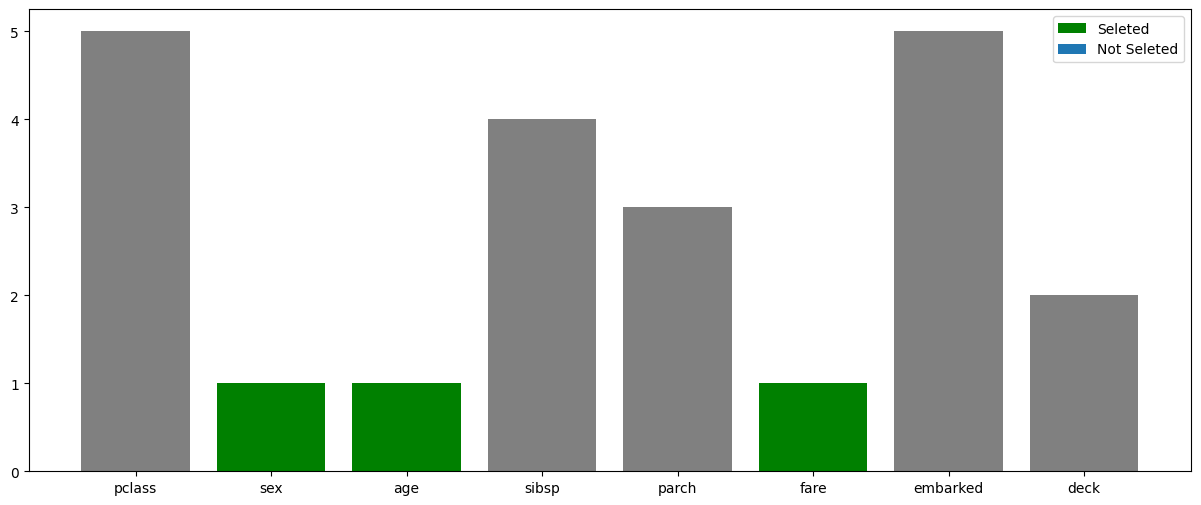

In [5]:
import matplotlib.pyplot as plt

green_area = X.columns[boruta_selector.support_].tolist()
blue_area = X.columns[boruta_selector.support_weak_].tolist()

# 중요도 랭킹으로 확인하기
feature_importance = boruta_selector.ranking_

# 시각화로 살펴보기
plt.figure(figsize=(15,6))
plt.bar(X.columns, feature_importance,color= 'grey')
plt.bar(green_area, [1]*len(green_area), color='green', label='Seleted')
plt.bar(blue_area, [2]*len(blue_area), color='blue', label='Not Seleted')
plt.legend()

### 초록색 (Selected):
- Boruta에 의해 중요한 피처로 선택된 변수들이다.
- 모델의 성능 향상에 기여할 가능성이 높은 피처이다.
- 예시: sex, age, fare 등이 중요한 변수로 선택되었다.
### 파란색 (Not Selected)
- Boruta가 약한 중요도로 분류한 피처이다.
- 모델에 크게 기여하지 않는다고 간주되어 제외할 가능성이 높다.
- 여기서는 파란색 막대는 보이지 않으므로 약한 중요도를 가진 변수는 없는 것으로 보인다.
### 회색 (Ranking)
- 변수별 중요도 순위를 나타낸다.
- 높은 값일수록 Boruta가 덜 중요한 변수로 판단한 것이다.
- 예시: pclass, sibsp, embarked, deck는 상대적으로 중요도가 낮다.

## 샤플리 값(Shapley Value) 이해하기
* 샤플리 값은 게임 이론에서 유래된 개념으로, **특성(플레이어)** 이 결과에 얼마나 기여했는지를 공정하게 계산하는 방법입니다. 머신러닝에서는 특성의 중요도를 평가하는 데 사용된다.

### 간단한 예시
* 세 명의 플레이어(특성) : A, B, C
* 이들이 협력하여 100의 매출을 달성.(머신러닝 모델로 보면 y=100을 예측)

### 조합별 기여도
* 기초 기여도
    * 공집합(∅): 아무도 참여하지 않으면 기여도 = 0
* 각 플레이어가 단독으로 기여한 경우
    * A : 20
    * B : 30
    * C : 10
* 두 명이 협력한 경우
    * A + B : 60
    * B + C : 50
    * A + C : 40
* 세 명이 모두 협력한 경우
    * A + B + C : 100

### 샤플리 값 계산(예 : A의 샤플리 값)
* 샤플리 값은 각 조합에서 A의 기여도를 계산하여 평균하는 방식이다. 즉, A가 포함된 모든 조합에서, A가 추가될 때 증가하는 값을 구한 뒤 평균을 낸다.
* 1. 조합별 기여도 변화 계산
    * 공집합 → A 추가 : 20-0 = 20
    * C → A+C : 40-10 = 30
    * B → A+B : 60-30 = 30
    * B+C → A+B+C : 100-50 = 50
* 2. 샤플리 값 계산
    * 샤플리 값은 각 기여도의 **가중 평균** 으로 계산된다. 가중치는 조합이 선택되는 경우의 수에 따라 다르다.
    * 1/6(A단독) : 1/6(20)
    * 1/6(A+C) : 1/6(30)
    * 1/6(A+B) : 1/6(30)
    * 1/6(A+B+C) : 1/6(50)
        * **샤플리 값(A) = 1/6(20)+1/6(30)+1/6(30)+1/6(50) = 21.67**

* Machine Learning에서 샤플리 값을 계산한다면?
    * Feature 모델의 예측값에 기여한 정도를 계산하기 위해 샤플리 값을 사용한다.
    * 피처들의 조합으로 게임 플레이어처럼 생각하고, 모델의 예측값을 협력의 결과로 본다.
    * 데이터 포인트에 대해 모델의 예측값 계산
    * 모든 특성의 조합에서의 예측값이 변화를 계산
    * 각 특성의 기여도를 평균화하여 샤플리 값을 계산

### 샤플리 값을 타이타닉 데이터로 설명을 해보면
- 타이타닉의 주요 특성(피처) pclass, sex, age, fare 타겟변수는 survived.
- 랜덤포레스트를 학습해서 특정 포인트에서 샤플리값을 계산해 본다.
----
- 특성 N은
    - Pclass(객실등급), Sex(성별), Age(나이), Fare(요금)
- **모든 특성의 조합을 생각해야 한다.**
    - 공집합,
    - Pclass
    - Sex
    - Age
    - Fare
    - (Pclass, Sex)
    - ...
    - (Pclass, Sex, Age, Fare)
    - 모든 조합을 생성한다.
- 모델의 예측값을 계산
    - 수식에서 바라보면
    - S = pclass i = sex , pclass와 sex를 함께 사용하여 예측값을 계산
    - f(SU{i} - f(S}) 특성인 sex 추가가 되었을 때 예측값에 미친 변화량을 계산
- 평균화
    - 모든 부분집합 (S)에 대한 기여도를 계산하는 것, 이를 평균화하여 특성 (i) 샤플리 값을 얻는 것
- 특정 데이터 포인트에 대해 샤플리값을 디 다계산이 된다.
- 변수     샤플리값     해석
- pclass  -0.3     낮은 객실등급들이 생존 확률을 감소시킨다.
- sex     +0.5     여성의 경우 생존확률 증가시킨다.
- age     -0.2     나이가 많아질수록 생존에 대한 확률이 감소
- fare    +0.1     운임이 높으면 생존확률을 증가시킨다.
    **- 타이타닉의 도메인을 이해하고 샤플리값을 바라보면 피처에 대한 선택과 인사이트를 상대적으로 쉽게 정리할 수 있다.**
    

In [19]:
from sklearn.model_selection import train_test_split

X= df[['sex','age','fare','pclass']]
y= df['survived']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=111)

In [21]:
model = RandomForestClassifier(random_state=111)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=111)

In [24]:
# Shap 값 구하기 
# SHAP Explainer 
explainer=shap.TreeExplainer(model)

In [25]:
# shap_values 추출
shap_values=explainer.shap_values(X_test)

In [26]:
shap_values

[array([[ 2.21466861e-01,  1.13594209e-01, -2.06209208e-01,
         -2.69185556e-04],
        [-1.50051199e-01, -7.65689293e-02, -6.35779054e-02,
         -2.12192893e-02],
        [ 3.06207651e-01,  3.82706060e-02,  2.08374207e-01,
          5.73021357e-03],
        [-1.94451182e-01, -5.48092467e-02, -6.84494051e-02,
         -3.70748949e-03],
        [ 2.00072782e-01, -3.04022517e-02, -1.16545064e-01,
         -4.54278848e-03],
        [-1.70773447e-01, -7.32136894e-02, -7.22896634e-02,
         -5.14052262e-03],
        [ 1.40922933e-01, -1.07910708e-01, -1.31836655e-01,
         -8.25928930e-02],
        [-2.37828513e-01, -5.93860237e-02, -1.95477555e-02,
         -4.65503021e-03],
        [-1.79819189e-01, -3.88502141e-02, -9.76501849e-02,
         -5.09773480e-03],
        [-9.26406082e-02, -8.11140981e-02,  2.02110475e-01,
         -9.77309155e-03],
        [-2.18466973e-01, -4.14364435e-02, -6.83902447e-03,
         -4.67488141e-03],
        [ 1.48782091e-01, -1.18395870e-01, 

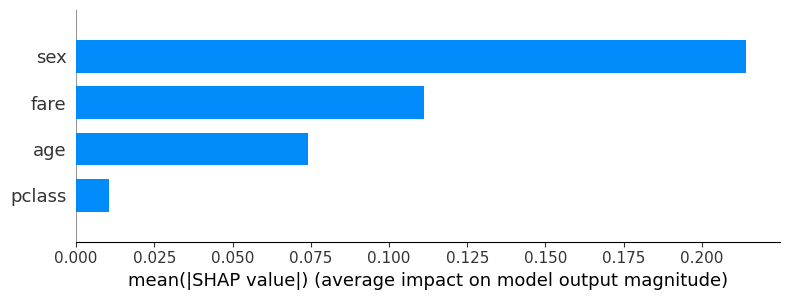

In [27]:
## shap 요약할 수 있는 시각화 플롯
shap.summary_plot(shap_values[0], X_test, plot_type='bar', feature_names= X_test.columns.tolist())

## Shap의 그래프를 더 살펴보고 해당 그래프를 해석해 보자

- summary_plot : 특정 중요도, 기여도 확인
- bar_plot : 중요도 순서 확인
- force_plot : 개별 예측 해석
- decision_plot : 예측 경로에 대한 분석
- dependence_plot : 특성과 출력간의 관계 분석
- interaction_plot : 상호작용 분석
- waterfall_plot : 예측 생성 과정 단계별 설명 
- heatmap_plot : 상호작용간의 분석
- beesarm plot : 분산, 중심성향 분석

In [29]:
## Shap값을 통해 중요도를 계산하고 확인해 보자!
shap_df=pd.DataFrame(shap_values[0], columns = X_test.columns)

In [30]:
## shap_df 중요도를 계산 후 정렬해서 보기
shap_mean_importance =shap_df.abs().mean(axis=0).sort_values(ascending=False)

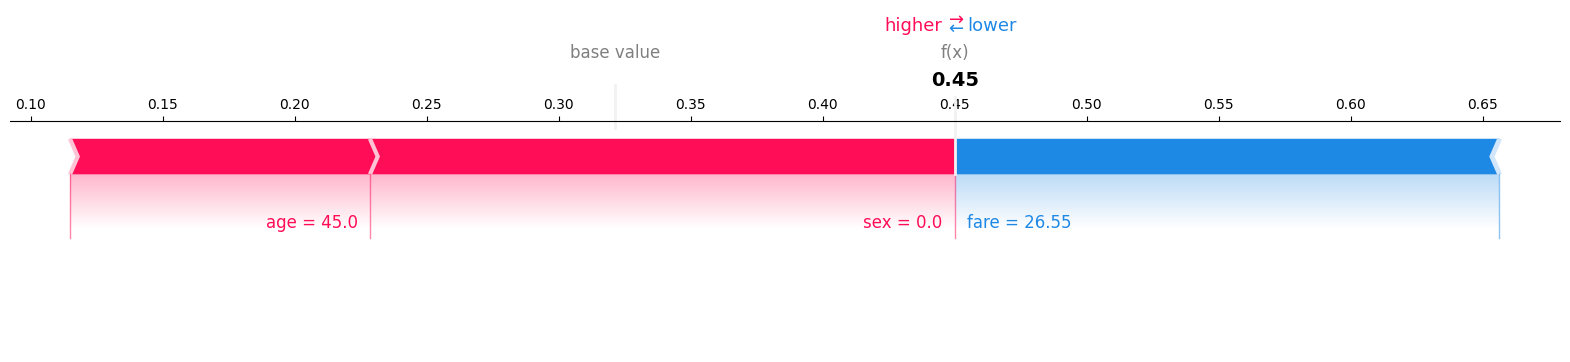

In [32]:
## Force_Plot
shap.force_plot(
    explainer.expected_value[0], # 모델의 base value (평균 예측값)
    shap_values[0][0,:], # 첫 번째 데이터 포인트에 대한 SHAP 값
    X_test.iloc[0,:], # 첫 번째 데이터 포인트 (특성 값)
    matplotlib=True    # force_plot을 matplotlib으로 렌더링
)

* x축 (base value ~ final prediction):
    * base value는 모델이 데이터 없이 예측할 때의 평균적인 출력값을 나타냅니다. 이 값은 기본적으로 예측 확률의 평균입니다.
    * 예측 값 f(x)는 모델이 입력 데이터를 고려한 최종 예측값으로, 이 예제에서는 0.45입니다.
* 영향 요소:
    * 빨간색은 값을 높이는 요인(positive impact)을, 파란색은 값을 낮추는 요인(negative impact)을 나타냅니다.
    * 예를 들어: age=45.0과 sex=0.0은 예측값을 증가시켰습니다. fare=26.55는 예측값을 감소시키는 방향으로 작용했습니다.
* 결론 : 
    * 이 그래프는 특정 데이터 포인트 (첫 번째 샘플)에 대한 예측 값이 어떻게 도출되었는지를 시각적으로 설명합니다.

- base_value 0.3에서 시작, 특성의 기여도를 더하거나 빼서 최종 예측값이 0.44로 도달한다.

- age 0.1증가킨다. 나이가 45일 때 생존 가능성을 증가하는 방향으로 작용
- sex 0 남성, 0.2 영향을 더 줬다.
- fare -0.206 영향 감소시켰다.

In [16]:
shap_values[0][0,:]

array([ 0.22146686,  0.11359421, -0.20620921, -0.00026919])

In [17]:
X_test.iloc[0,:]

sex        0.00
age       45.00
fare      26.55
pclass     1.00
Name: 536, dtype: float64

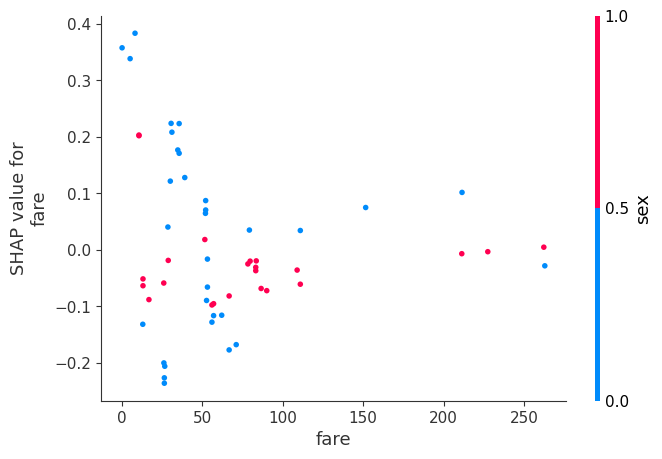

In [18]:
# 요금에 따른 shap의 관계를 확인하자
shap.dependence_plot('fare',shap_values[0],X_test)

### 그래프 해석
* SHAP 값의 변화
    * fare 값이 증가할수록 SHAP 값도 증가하는 경향이 보입니다. 이는 높은 요금을 지불한 승객일수록 모델이 긍정적인 결과 (예: 생존 확률 증가)를 예측할 가능성이 높다는 것을 의미한다.
    * 낮은 fare 값에서는 SHAP 값이 음수로 나타나는 경우가 많습니다. 즉, 낮은 요금은 예측 결과에 부정적으로 작용한다.
* 성별의 영향
    * 그래프에서 성별(sex)이 SHAP 값에 미치는 추가적인 영향을 확인할 수 있다.
    * 같은 fare 값에서도 남성(파란색)과 여성(빨간색)의 SHAP 값 분포가 약간 다릅니다. 예를 들어, 여성은 더 높은 SHAP 값을 가질 가능성이 있는 것으로 보인다. 이는 성별이 모델의 예측에 추가적인 역할을 한다는 것을 시사한다.
* 극단적인 fare 값
    * 높은 fare 구간 (예: 200 이상)에서는 데이터 점이 적지만, 이 구간의 SHAP 값은 항상 양수다. 이는 매우 높은 요금을 지불한 승객은 예측 결과에 긍정적으로 기여했음을 보여준다.


### SHAP Dependence Plot의 역할
* 특성 간 상호작용 이해: 이 플롯은 주 특성 (fare)과 다른 특성 (sex)의 상호작용을 포함하여 모델의 예측에 미치는 영향을 시각화한다.
* 모델 동작 파악: 특성 값이 모델 예측에 어떻게 기여하는지 직관적으로 확인할 수 있다.

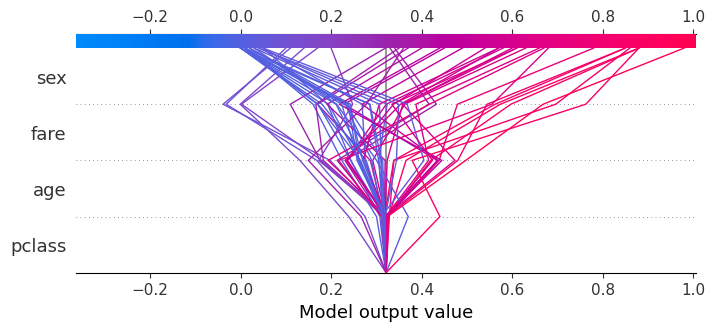

In [19]:
shap.decision_plot(
    explainer.expected_value[0],
    shap_values[0],
    X_test
)

### 그래프 구성 요소
* x축 (Model output value)
    * 모델이 특정 데이터 포인트에 대해 예측한 값입니다. 값의 범위는 약 -0.2에서 1.0 사이이다.
    * 이 값은 모델의 출력값으로, 예를 들어 이진 분류 문제라면 "생존 확률"을 나타낼 수 있다.
* y축 (특성들)
    * 모델의 예측에 영향을 미친 주요 특성들의 목록이다 (sex, fare, age, pclass).
    * 각 특성이 예측 결과에 어떻게 기여했는지를 시각적으로 나타낸다.
* 선의 경로 (기여도)
    * 각 선은 하나의 데이터 샘플을 나타낸다.
    * 선의 시작점은 모델의 base value(평균 출력값)이고, 끝점은 해당 데이터 샘플의 최종 예측값이다.
    * 선이 위로 이동하면 해당 특성이 예측값을 증가시키는 방향으로 작용했음을, 아래로 이동하면 감소시키는 방향으로 작용했음을 의미한다.
* 색상
    * 선의 색상은 sex 특성 값을 나타낸다.
    * 파란색: sex = 0 (일반적으로 남성).
    * 빨간색: sex = 1 (일반적으로 여성).

### 그래프 해석
* sex의 기여
    * 성별(sex) 특성이 가장 상단에 위치하며, 예측에 큰 영향을 미쳤다.
    * 빨간색 선(여성)은 예측값을 증가시키는 방향으로, 파란색 선(남성)은 감소시키는 방향으로 주로 작용했다. 이는 성별이 생존 확률에 중요한 역할을 한다는 것을 나타낸다.
* fare의 기여
    * fare는 탑승 요금으로, 선의 경로에서 이 특성이 예측값을 증가시키는 데 기여한 경우가 많다.
    * 특히 높은 요금을 지불한 경우 SHAP 값이 양수로 작용하여 예측값을 증가시킨 것으로 보인다.
* age와 pclass의 기여
    * age와 pclass는 상대적으로 영향이 다양하게 분포되어 있다.
    * 예를 들어: 어린 연령대는 예측값을 증가시키는 경우가 많고, pclass는 1등급일수록 예측값에 긍정적인 영향을 미쳤을 가능성이 있다.
* 전체 경향
    * 그래프에서 선의 경로가 여러 특성을 통과하며 이동하는 모습을 통해, 모델이 어떻게 각 특성을 조합해 최종 예측값을 도출했는지 알 수 있다.
    * 많은 빨간색 선은 높은 예측값(예: 생존 확률)으로 끝나는 반면, 파란색 선은 낮은 예측값으로 끝나는 경우가 많다.

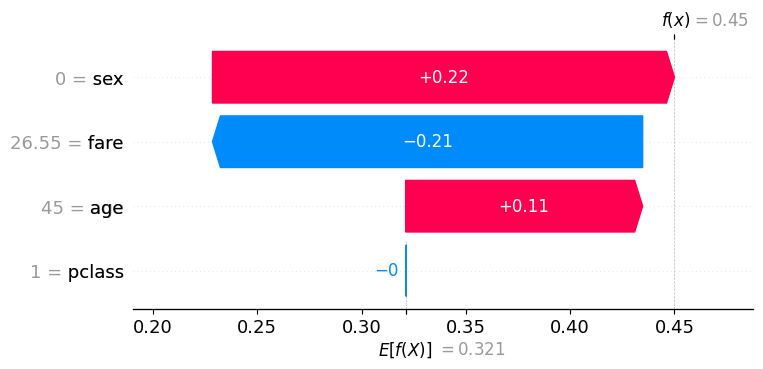

In [20]:
## 0번째 피처의 특성들에 shap 값 보면서 확인하는 것
shap.waterfall_plot(
    shap.Explanation(
    values= shap_values[0][0],
    base_values = explainer.expected_value[0],
    data = X_test.iloc[0])
)

* sex: +0.22로 긍정적인 영향을 미치며, 예측 값을 높입니다.
* fare: -0.21로 부정적인 영향을 미쳐, 예측 값을 낮추는 역할을 합니다.
* age: +0.11로 예측 값을 약간 높이는 기여를 합니다.
* pclass: 0으로, 예측 값에 영향을 주지 않는 것으로 나타납니다.
* 최종 예측 값인 ( f(x) = 0.45 )는 기본값 ( E[f(X)] = 0.321 )에서 각 특성의 기여를 더한 결과입니다. 이와 같은 분석을 통해 어떤 특성이 모델의 예측에 큰 영향을 미치는지를 파악할 수 있습니다.

In [33]:
## shap값을 통해 출력된 피처와 base 모델로 학습한 것을 비교하여 정말 피처 셀렉션이 긍정적인 영향을 주는가?
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [22]:
tt=sns.load_dataset('titanic')

In [23]:
tt=tt.drop(columns = ['deck','embark_town','class','alive','who','adult_male','alone'])

In [24]:
## 간단한 전처리
## 결측치는 다 제거하기
tt=tt.dropna()

In [25]:
tt

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
889,1,1,male,26.0,0,0,30.0000,C


In [26]:
tt['sex'] = tt['sex'].map({'male':0,'female':1})
tt['embarked'] = tt['embarked'].map({'C':0,'Q':1,'S':2})
# 전처리 다 진행

In [27]:
## X, y 로 데이터 나누기
X = tt.drop(columns = ['survived'])
y = tt['survived']

In [35]:
import numpy as np

In [38]:
## 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=111)
## cross_val
## base라인 모델링
rf_base=RandomForestClassifier(random_state=111, max_depth=2)
base_cv_scores=cross_val_score(rf_base, X_train, y_train, cv=5, scoring='accuracy')
print(f"교차검증 train : {np.mean(base_cv_scores)}")
## test 값으로 실제 성능 확인
rf_base.fit(X_train, y_train)
base_pred = rf_base.predict(X_test)
base_acc_test = accuracy_score(y_test, base_pred)
print(f"test 결과 : {base_acc_test}")

## shap 피처 셀렉한 것으로 모델링
explainer = shap.TreeExplainer(rf_base)
shap_values = explainer.shap_values(X_train)

교차검증 train : 0.8107692307692307
test 결과 : 0.7272727272727273


In [40]:
## shap 중요도 계산
## 피처에 적용하기
shap_importance=np.abs(shap_values[1]).mean(axis=0)
importance_features =X_train.columns[np.argsort(shap_importance)][::-1][:2]

## trian 데이터에서 특성으로 추출
X_train_selected = X_train[importance_features]
X_test_selected = X_test[importance_features]

In [41]:
rf_selected=RandomForestClassifier(random_state=111, max_depth=2)
selected_cv_scores=cross_val_score(rf_selected, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"교차검증 train : {np.mean(selected_cv_scores)}")

## test 검증
rf_selected.fit(X_train_selected, y_train)
selected_y_pred = rf_selected.predict(X_test_selected)

# 정확도 측정
selected_acc_test = accuracy_score(y_test, selected_y_pred)
print(f"test 결과 : {selected_acc_test}")


교차검증 train : 0.787076923076923
test 결과 : 0.7090909090909091


In [32]:
## 피처의 중요도를 선택했을 때 오히려 더 안 좋은 성능을 보였다.
## 데이터 수가 너무 적은 것도 있고, 전처리 안 하고 날려서 성능을 비교하는 게 좀 너무 적고
## 전처리나 다른 피처에 대한 엔지니어링 작업도 없었고,
## 이미 데이터 자체가 피처가 빠지면 성능이 떨어질 수 밖에 없는 설명력의 상황일 수 있다.
## train 훨씬 낮고 test가 높은 과소적합의 상태이기 때문에 이 부분을 이야기하게는 모순이다.